## learning-AI101 : topic3_4

### image classification 
**개-고양이 분류 문제 (https://www.kaggle.com/competitions/dogs-vs-cats/data)**  
  
train : 25000개 이미지   
test : 12500개 이미지  
label :  
- 0 : 강아지   
- 1 : 고양이  

In [19]:
# 이미지 파일 갯수 새보기

import os
import tensorflow as tf
import shutil

print ("train데이터 :", 25000)
print ("test데이터 :", len(os.listdir('../data/dogs-vs-cats/test1/')))

train데이터 : 25000
test데이터 : 12500


현재 이미지는 jpg나 png같은 이미지 형식으로 되어있기 때문에 픽셀 단위로 색깔값변환 해줘야함   
- 1) opencv 라이브러리로 이미지를 숫자화한다
  2) **tf.keras를 이용한다**
- tf.keras.preprocessing.image_dataset_from_directory()를 이용할 것인데,  
  하기 전에 강아지는 강아지대로, 고양이는 고양이대로 폴더를 나눠서 저장해두어야 함 (그래야지 분류를 함)

In [17]:
# 강아지, 고양이 폴더 만들기

os.mkdir("../data/dogs-vs-cats/dog/")
os.mkdir("../data/dogs-vs-cats/cat/")

# 강아지는 강아지폴더에, 고양이는 고양이폴더에 나누어서 저장해두기

for file in os.listdir('../data/dogs-vs-cats/train/') :
    if 'cat' in file : 
        shutil.move('../data/dogs-vs-cats/train/' + file, '../data/dogs-vs-cats/cat/' + file)

    else : 
        shutil.move('../data/dogs-vs-cats/train/' + file, '../data/dogs-vs-cats/dog/' + file)

else :
    print ("파일 옮기기 성공")

파일 옮기기 성공


In [23]:
# 강아지 폴더, 고양이 폴더, train 폴더 각각 파일갯수가 몇개인지 새보기

print ("강아지 train :", len(os.listdir('../data/dogs-vs-cats/dog/')))
print ("고양이 train :", len(os.listdir('../data/dogs-vs-cats/cat/')))
print ("train 폴더 (전부 옮겼으니깐 0) :", len(os.listdir('../data/dogs-vs-cats/train/')))

강아지 train : 12500
고양이 train : 12500
train 폴더 (전부 옮겼으니깐 0) : 0


In [27]:
# dog랑 cat을 dataset 디렉토리에 같이 넣기

os.mkdir ('../data/dogs-vs-cats/dataset/')
shutil.move('../data/dogs-vs-cats/cat', '../data/dogs-vs-cats/dataset/cat')
shutil.move('../data/dogs-vs-cats/dog', '../data/dogs-vs-cats/dataset/dog')

'../data/dogs-vs-cats/dataset/dog'

---------

**tf.keras.preprocessing을 이용해 이미지 형식을 숫자화한다**  
- 경로 적기
- 모든 이미지의 크기 (픽셀 기준)
- 미니배치의 사이즈 (이미지 2만장 한번에 넣지 않고 batch 숫자만큼 여러번 넣어서 학습)
- subset="training"  
  validation_split=0.2 <==== 검사 (validation_ds를 만들어야함)

결과(train_ds)는 2차원 튜플 형식으로,   
- 첫번째 : 이미지 수치화
- 두번째 : label (0 : 강아지, 1 : 고양이)

In [66]:
# tf.keras.preprocessing을 이용해 이미지 형식을 숫자화한다

# train_ds : 이미지를 수치화
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/dogs-vs-cats/dataset/',
    image_size = (64, 64),
    batch_size = 64, 
    subset = 'training',
    validation_split = 0.2,
    seed = 1234
)

# val_ds : validation 데이터셋
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/dogs-vs-cats/dataset/',
    image_size = (64, 64),
    batch_size = 64, 
    subset = 'validation',
    validation_split = 0.2,
    seed = 1234
)

# 결론적으로 train데이터 중 80%는 train_ds, 20%는 val_ds에 있다 

print (train_ds)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


-----------

### 전처리 (속도를 위해)

지금 현재 숫자는 0~255의 값을 가지고 있다.  
하지만 지금 이대로 학습시키면 학습속도가 기하급수적으로 늘어난다.  
따라서 **0-1로 숫자들을 압축** 하여 빠르게 계산 가능하도록 전처리해준다.

In [67]:
# 압축할 때 map 사용 (map 안에는 전처리함수 사용)

def 전처리함수(numeric_image, label) : 
    numeric_image = tf.cast(numeric_image/255.0, tf.float32) # 255로 나누어서 0~1 사이의 값으로
    return numeric_image, label
    
train_ds = train_ds.map(전처리함수)
val_ds = val_ds.map(전처리함수)

In [68]:
# 모델 만들기 전에 dataset의 dog와 cat을 출력해보자

for numeric_image, label in train_ds.take(1) : # 데이터 중 아무거나 하나 뽑아서 그 안에 있는거 확인해보자
    print (numeric_image, "|", label)

tf.Tensor(
[[[[0.08425054 0.02934857 0.02542701]
   [0.0788603  0.02395833 0.02003676]
   [0.09209559 0.04895834 0.03327206]
   ...
   [0.06710516 0.02360026 0.00803654]
   [0.07450981 0.01960784 0.01568628]
   [0.00392923 0.00803654 0.00392923]]

  [[0.1010972  0.0501168  0.02658739]
   [0.119267   0.06828661 0.0447572 ]
   [0.06590265 0.03845167 0.01492226]
   ...
   [0.07071079 0.02720588 0.01164216]
   [0.06977443 0.01487247 0.0109509 ]
   [0.00349839 0.01146408 0.00509153]]

  [[0.09571078 0.04473039 0.01335784]
   [0.09761029 0.0466299  0.01525735]
   [0.07900965 0.066142   0.03922909]
   ...
   [0.07178692 0.02703546 0.01188726]
   [0.0753753  0.02147863 0.01722197]
   [0.00857843 0.01602137 0.00982307]]

  ...

  [[0.3947572  0.32857114 0.24108073]
   [0.46586245 0.3835095  0.26279873]
   [0.5416322  0.4666322  0.34874004]
   ...
   [0.46569967 0.29682714 0.0887389 ]
   [0.37026656 0.20948224 0.0077742 ]
   [0.4407437  0.29987362 0.05557215]]

  [[0.48482114 0.40479666 0.296574

input_shape는 (64, 64, 3)이다. (마지막 값은 컬러라 (RGB))
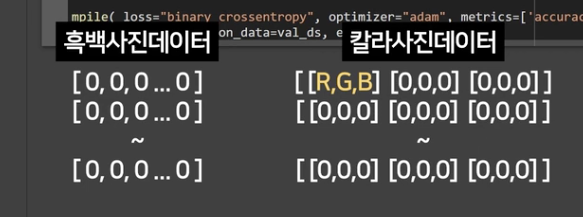

-------

### 1) 모델 만들기

둘 중 무엇인가를 해결하기 위해선 손실함수는 **'binary_crossentropy'**,  
마지막 레이어엔 **'sigmoid'** 적용  
마지막 정답이 하나이기 때문에 (개인지, 고양이인지) 노드갯수를 1로

**overfitting**을 막기 위해 중간에 Dropout 레이어 삽입 (중간에 노드 떨구기)

In [69]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D( (2, 2) ),
    tf.keras.layers.Dropout(0.2), # 중간에 노드 20% 떨구기
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D( (2, 2) ),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D( (2, 2) ),
    tf.keras.layers.Dropout(0.2), # 중간에 노드 20% 떨구기
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"), # 개일 확률, 고양이일 확률
])

In [70]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)       

----------

### 2) 컴파일 후 학습

classification 문제에서 이것이 둘 중 무엇인가를 해결하기 위해선  
손실함수에 **'binary_crossentropy'** 를 적용해야 한다.

In [71]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.fit (train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
313/313 [==============================] - 46s 141ms/step - loss: 0.6283 - accuracy: 0.6321 - val_loss: 0.5856 - val_accuracy: 0.6834
Epoch 2/5
313/313 [==============================] - 46s 145ms/step - loss: 0.5240 - accuracy: 0.7354 - val_loss: 0.5091 - val_accuracy: 0.7552
Epoch 3/5
313/313 [==============================] - 45s 142ms/step - loss: 0.4770 - accuracy: 0.7723 - val_loss: 0.4399 - val_accuracy: 0.7970
Epoch 4/5
313/313 [==============================] - 45s 143ms/step - loss: 0.4332 - accuracy: 0.7982 - val_loss: 0.3915 - val_accuracy: 0.8264
Epoch 5/5
313/313 [==============================] - 46s 146ms/step - loss: 0.3964 - accuracy: 0.8177 - val_loss: 0.3787 - val_accuracy: 0.8300


In [86]:
# predict를 위한 test 이미지 수치화

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/alphastation/repository/learning-AI101/data/dogs-vs-cats/test',
    image_size = (64, 64)
)

print (test_ds.take(1))

Found 12500 files belonging to 1 classes.
<_TakeDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [87]:
for numeric_image, label in test_ds.take(1) : # 데이터 중 아무거나 하나 뽑아서 그 안에 있는거 확인해보자
    print (numeric_image)

tf.Tensor(
[[[[1.18502197e+01 5.20455322e+01 5.85021973e+00]
   [2.50466309e+01 7.16560059e+01 2.66325684e+01]
   [1.01562500e-01 1.94888306e+01 9.37500000e-02]
   ...
   [5.68247681e+01 7.48325806e+01 5.28515625e+01]
   [2.00914917e+01 3.23240967e+01 1.03729248e+00]
   [4.37055664e+01 9.53149414e+01 9.25378418e+00]]

  [[6.21673584e+00 4.64120483e+01 1.59375000e+00]
   [3.87457275e+01 8.53551025e+01 4.03316650e+01]
   [4.47534180e+00 2.11270752e+01 6.05224609e+00]
   ...
   [1.20244751e+01 3.23269043e+01 6.26220703e-01]
   [1.03636475e+01 2.94886475e+01 0.00000000e+00]
   [9.53326416e+00 6.85178833e+01 2.07989502e+00]]

  [[4.39508057e+00 4.39375000e+01 5.33447266e-01]
   [2.78883667e+01 7.36361084e+01 2.92064209e+01]
   [1.55720825e+01 2.71970825e+01 1.74158325e+01]
   ...
   [5.92117920e+01 8.11594238e+01 1.70703125e+01]
   [1.41632080e+00 1.48992920e+00 2.33795166e+01]
   [5.52243652e+01 1.13664124e+02 1.43817139e+01]]

  ...

  [[1.41487732e+02 1.36123901e+02 1.35254456e+02]
   [1

In [90]:
predictions = model.predict(numeric_image)

1/1 [==============================] - 0s 40ms/step


In [91]:
print (predictions)

# 1e0은 확률이 1이라는 뜻이고 0e0은 확률이 0이라는 뜻

[[1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [3.6931902e-02]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [7.2347391e-13]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
